# Fanal

## A neutrino-less beta decay experiment 

## An open exercise

## Calibration


### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, 

with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro

February 2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [3]:
import core.pltext as pltext
import core.hfit   as hfit
import core.utils  as ut

pltext.style()

## Indications

### Objective

**Estimate the energy resolution** and **the energy scale of the detector**. For that, we will fit some peaks a 208Tl calibration sample to its know tabulated energy.

### Tasks:

   * Open the data file (HDF) and access the mock calibration data (cal) obtained with a 208Tl source.

   * Fit the energy of the main track (track0) to the main photo-peak (2.615 MeV) and double-scape peak.
   
   * Fit the energy of the secon track (track1) to other Tl gamma lines
   
   * Calibrate the measured energy of the peacks with respect the tabulated energy.

### Notes:

   * The main photo-peak is at 2.615 MeV. This peak can suffer Compton, Bremsstrahlung and pear production. A double-scape peak is expected at 2.615 - 2 * 511 keV. 
  
   * There are other minor 208Tl gamma lines at 860, 583 and 511 keV. 
  
   * Sometimes the photo-peak is produced with an associated 126Xe X-ray of 30 keV.

## Access the data

In [4]:
dirpath = '/Users/hernando/investigacion/NEXT/work/ICAROSNB/JAH/fanal/data/'

In [5]:
filename = 'fanal_alpha.h5'

calib = pd.read_hdf(dirpath + filename, key = 'data/tl208')

### list of variables



In [6]:
calib

,E,num_tracks,num_voxels,track0_E,track0_voxels,track0_length,blob1_E,blob2_E,track1_E,track1_voxels,track1_length,voxels_minZ,voxels_maxZ,voxels_maxRad
914160,2.466622,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,378.826092,1246.698750,528.425209
356979,2.964067,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.470308,640.793051,527.537687
993955,2.473121,4.0,24,2.142168,20.0,125.772423,NaN,NaN,0.168682,2.0,9.885189,561.473142,1254.679629,442.778202
922005,2.639489,4.0,33,2.306041,28.0,68.062635,NaN,NaN,0.167528,3.0,17.108280,69.206628,1160.906745,506.193643
850252,2.420345,4.0,30,1.891394,26.0,110.823715,NaN,NaN,0.223267,1.0,0.000000,723.603419,1184.793310,441.942793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990369,3.373822,7.0,37,2.011914,25.0,152.784223,NaN,NaN,0.553392,3.0,14.044773,35.362971,1182.737125,496.467080
343989,2.465966,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,573.924914,846.756726,524.951151
307619,2.863028,3.0,28,2.365999,25.0,167.628381,NaN,NaN,0.252716,2.0,9.931894,114.192663,348.886874,504.285121
1057095,2.608906,3.0,29,2.262927,24.0,91.367538,NaN,NaN,0.189761,4.0,13.651353,691.527694,805.830522,262.018866


## Histogram the variables

We are drawing the variables only in the relevant range (2.6, 2.8 MeV)

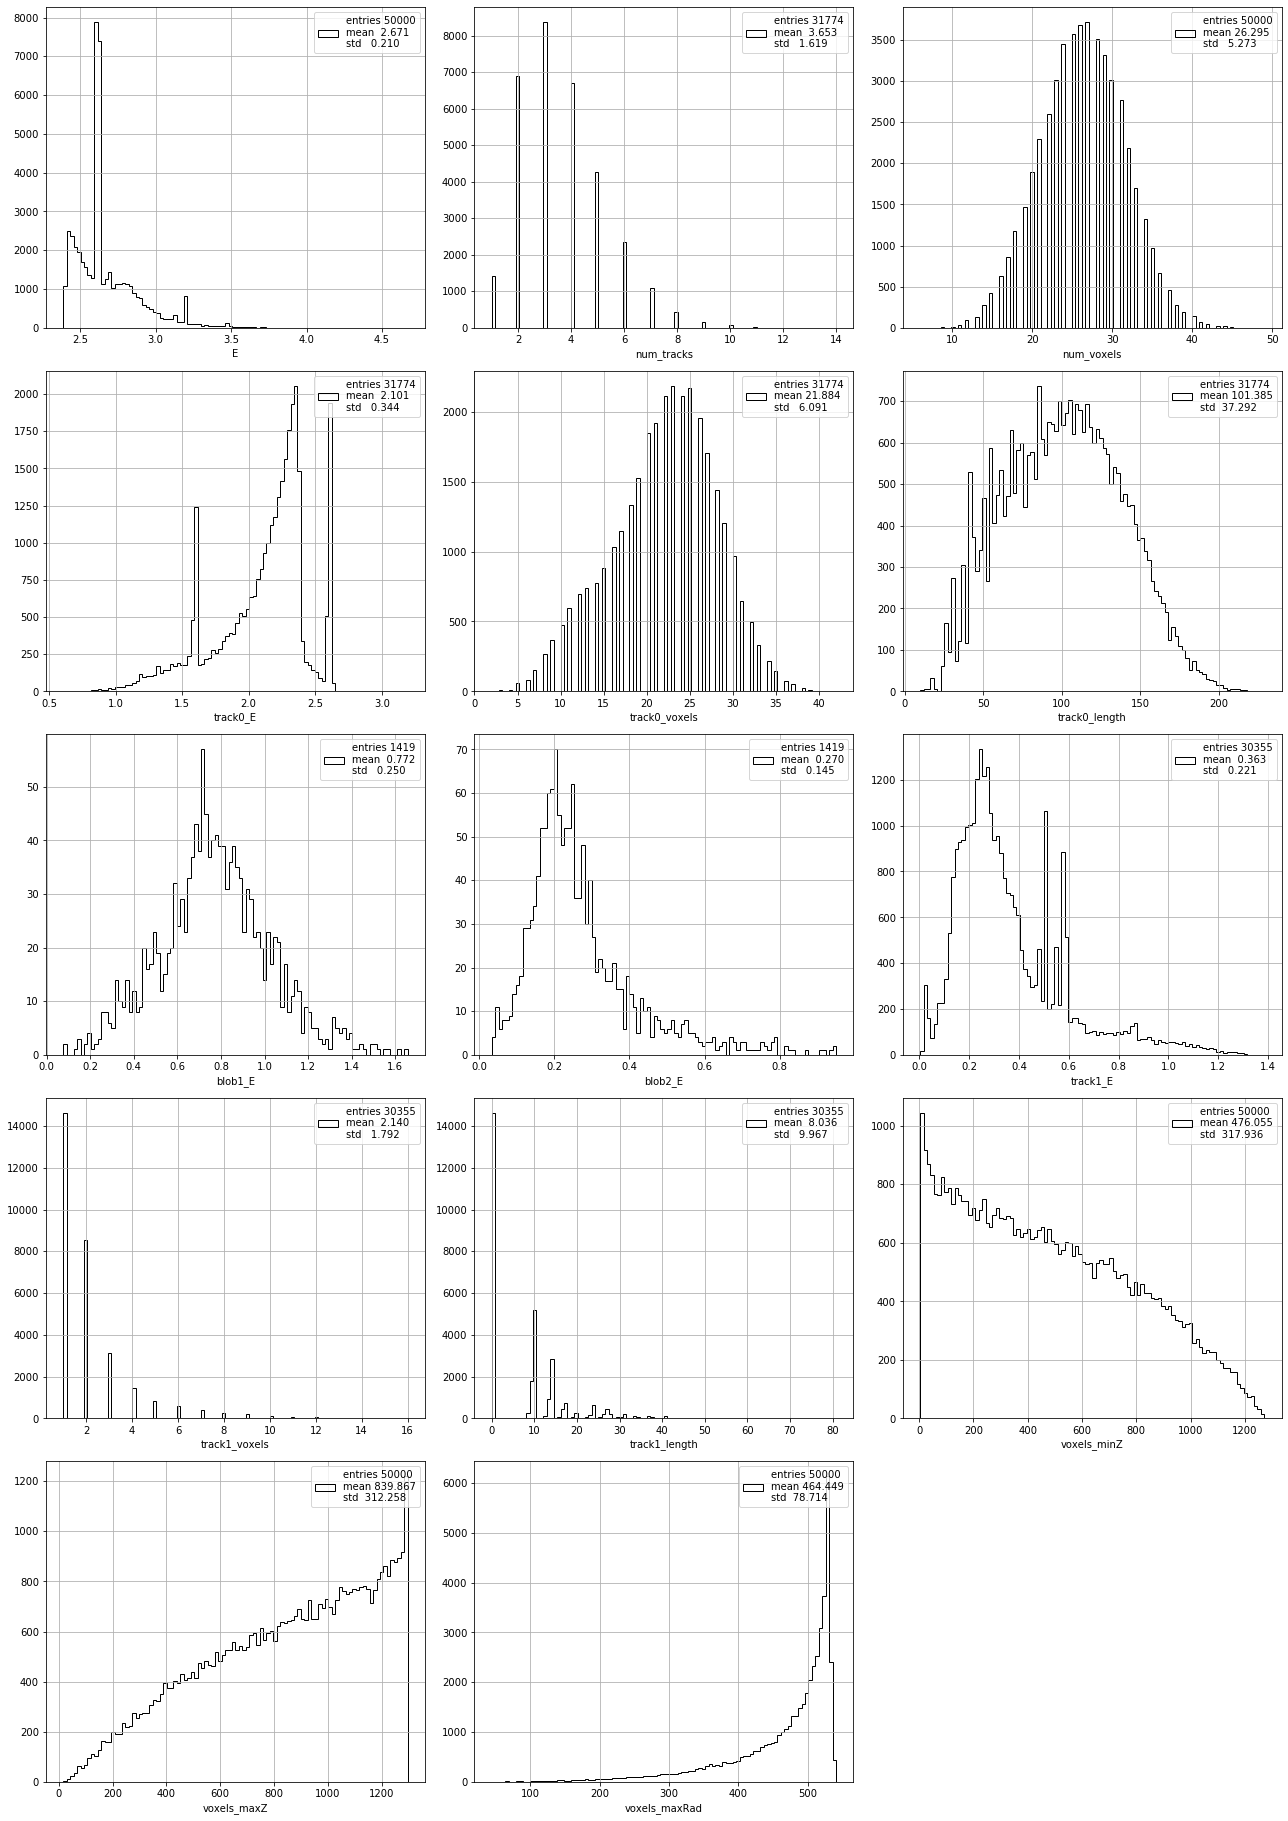

In [7]:
pltext.df_inspect(calib, ncolumns = 3)

## Energy calibration, identifying the peaks

In [8]:
# utitility function
def efit(enes, bins, erange, guess = None):
    guess  = (len(enes), np.mean(enes), 20., 10., 0.) if guess is None else guess
    sel    = ut.in_range(enes, erange)
    pars, cpars = pltext.hfit(enes[sel], bins, fun = 'gausline', guess = guess, range = erange);
    return pars, cpars

### Photo-peak and double-escape

Study the energy of the track-0.

Fit the photo-peak and the double-escape peak

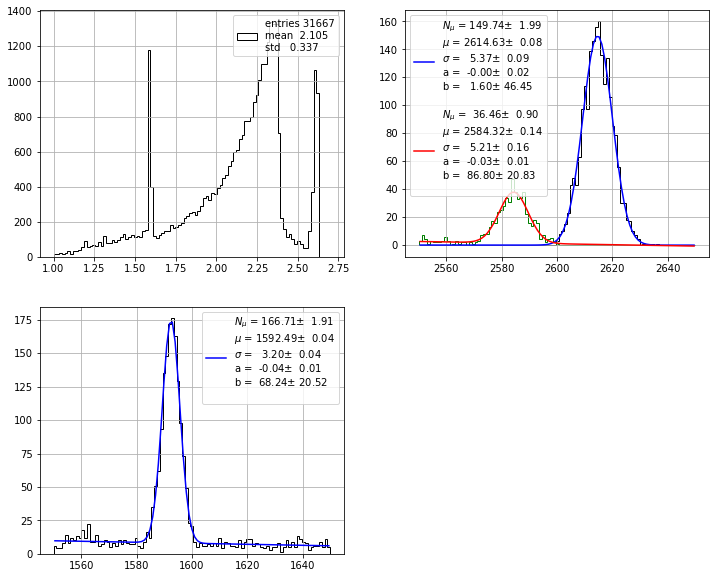

In [9]:
enes   = 1e3 * ut.remove_nan(calib.track0_E.values) # energy in keV and remove NaN

calpars = []

subplot = pltext.canvas(4)

subplot(1)
pltext.hist(calib.track0_E, 100, range = (1., 2.7));

subplot(2)
erange = (2600, 2650) 
guess  = (1e3, 2615, 20., 20., 0.)
bins   = np.linspace(2550, 2650, 100) 
pars, cpars = efit(enes, bins, erange, guess);
calpars.append( (pars, cpars))
erange = (2550-50, 2650 - 50) 
guess  = (1e2, 2615 - 50, 20., 20., 0.)
pars, cpars  = efit(enes, bins, erange, guess);


subplot(3)
erange = (1550, 1650) 
bins   = np.linspace(*erange, 100) 
guess  = (1e3, 1560, 20., 20., 0.)
pars, cpars = efit(enes, bins, erange, guess)
calpars.append( (pars, cpars))

## Other Tl peaks

Study the energy of track-1. 

Identify the peaks.

Fit then to a gaussian.

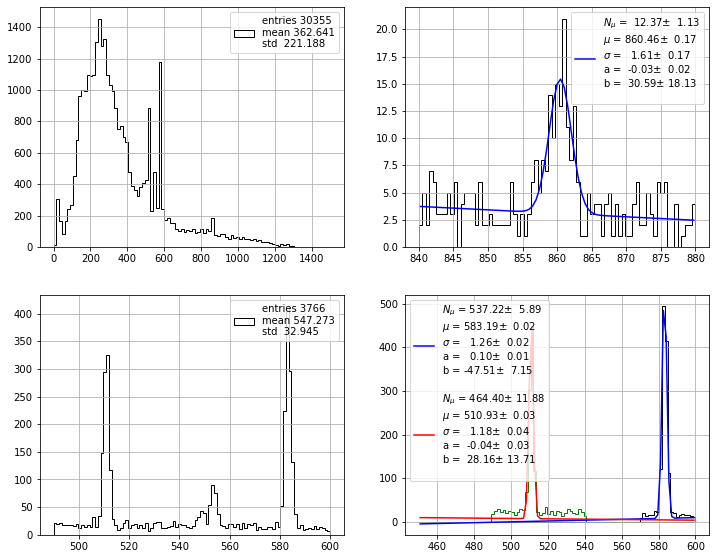

In [10]:
enes   = 1e3 * ut.remove_nan(calib.track1_E.values) # energy in keV and remove NaN

subplot = pltext.canvas(6)

subplot(1)
pltext.hist(enes, 100, range = (0., 1500.));

subplot(2)
erange = (840, 880.) 
bins   = np.linspace(*erange, 80) 
guess  = (1e2, 860, 5., 0., 0.)
pars, cpars = efit(enes, bins, erange, guess)
calpars.append( (pars, cpars))


subplot(3)
xrange  = (490., 600.) 
pltext.hist(enes, 100, range = xrange)

subplot(4)
erange = (570, 600.) 
bins   = np.linspace(450, 600, 100) 
guess  = (1e2, 585, 5., 0., 0.)
pars, cpars = efit(enes, bins, erange, guess)
calpars.append( (pars, cpars))

erange = (490, 540.) 
guess  = (1e2, 511, 5., 0., 0.)
pars, cpars = efit(enes, bins, erange, guess)
calpars.append( (pars, cpars))

## Energy Scale calibration

Relate the measured peaks positions to the tabulated one. 

Fit to a line.

If there are deviation respect unity use this line to calibrate your detector.


In [11]:
xvals  = np.array([511., 583., 860., 2615. - 2 * 511, 2615.])
calpars.reverse()
yvals  = np.array([val[0][1] for val in calpars])
eyvals = np.array([val[1][1] for val in calpars])

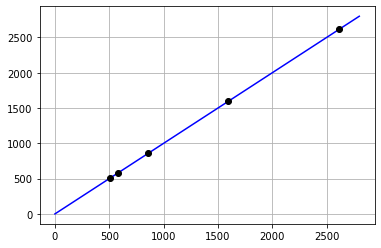

In [12]:
plt.errorbar(xvals, yvals, yerr = 1.5* eyvals, ls = '', marker = 'o')
xs = np.linspace(0., 2800, 100)
plt.plot(xs, xs); plt.grid();

In [13]:
import scipy.optimize as optimize

def fline(x, a, b):
    return a * x + b

#par, cov = optimize.curve_fit(fline, xvals, yvals, sigma = 1.5 * eyvals, p0 = (1., 0.), absolute_sigma = True)

par, cov = optimize.curve_fit(fline, xvals, yvals, sigma = 1.5* eyvals, p0 = (1., 0.))
chi2     = np.sum(((fline(xvals, *par) - yvals))**2)
epar = np.sqrt(np.diag(cov)) 
print(r'calibration scale     : {0:6.4f} +/- {1:6.4f}'.format(par[0], epar[0]))
print(r'calibration threshold : {0:6.4f} +/- {1:6.4f}'.format(par[1], epar[1]))
print(r'resolution near  Qbb  : {0:6.3f} % FWHM '.format(235. * abs(calpars[-1][0][2])/calpars[-1][0][1]))

calibration scale     : 0.9996 +/- 0.0002
calibration threshold : 0.3807 +/- 0.1554
resolution near  Qbb  :  0.482 % FWHM 


### Additional notes

These are the decay diagrams of 214Bi and 208Tl. 

Several lines can be observed in the total energy and track-0 and track-1 energies. 

Notice that the 1.615 MeV gamma can produrce electron-positron pairs and a double-scape peak when the photons produced by the positron capture scape the detector, the double-scape peak has an energy of $1.615 - 2 \; 0.511$ MeV


<img src="img/214-Bi-and-208-Tl-decay-diagrams.png" width="800" height="400">